<a href="https://colab.research.google.com/github/ensf411-winter-2022/dl-lab5-ryanbakerucalgary/blob/main/lab5_micro_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

- Chose to use more data (option 2: "Share and grab more data"). Note that the data in the provided OneDrive folder was available under a [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.


# 2. Model training and Results
Any code to train a model and produce results or a reference to the notebook/code file.

Mounted at /content/gdrive


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.833605,1.076528,0.585417,04:07


epoch,train_loss,valid_loss,accuracy,time
0,0.886634,0.466578,0.829167,04:43
1,0.536867,0.288492,0.879167,04:42
2,0.301305,0.226475,0.922917,04:42
3,0.188536,0.153059,0.939583,04:42
4,0.126996,0.090503,0.966667,04:42
5,0.079693,0.087926,0.972917,04:43


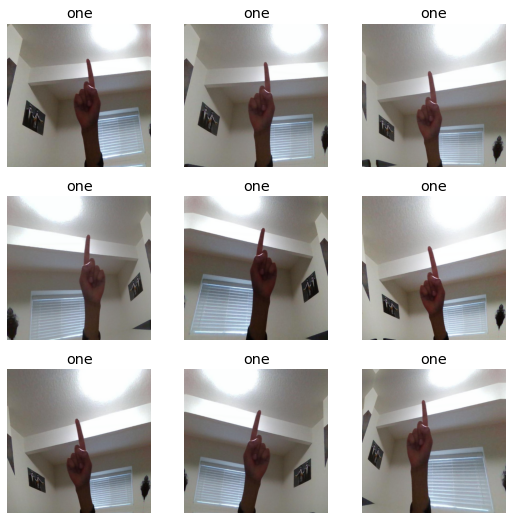

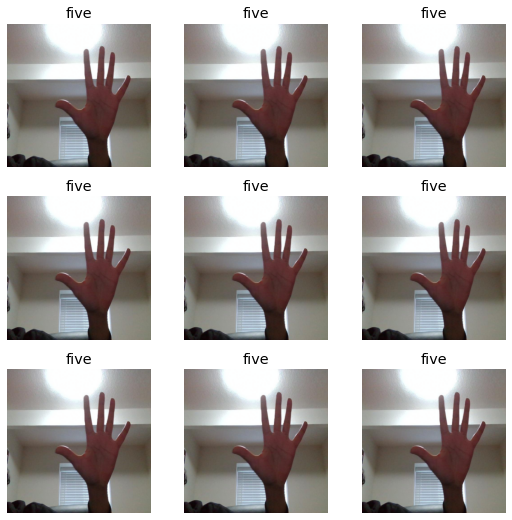

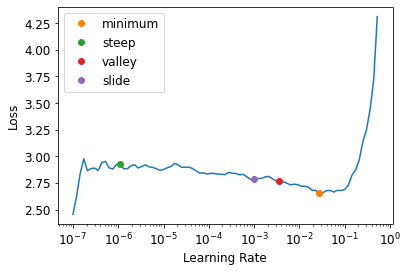

In [1]:
# ran from colab

!pip install -q fastbook

import fastbook
fastbook.setup_book()

from fastai.vision.all import *

path = Path('/content/gdrive/MyDrive/ColabNotebooks/digits')

seed_val = 25
set_seed(seed_val)

def get_parent_as_list(x): return [parent_label(x)]
fingers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    # blocks=(ImageBlock, MultiCategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), #40 training, 10 validation images per finger
    get_y=parent_label, # get the label from the directory name
    # get_y=get_parent_as_list, # get the label from the directory name
    item_tfms=Resize(640, ResizeMethod.Squish), # resize to 640x640 px; use Squish so fingers aren't cropped
    batch_tfms=aug_transforms(size=420, flip_vert=False, max_zoom=1.0, min_zoom=1.0, max_rotate=5)) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

dls = fingers.dataloaders(path, bs=32)

dls.train.show_batch(unique=True)
dls.valid.show_batch(unique=True)

set_seed(seed_val)

learn = cnn_learner(dls, resnet18, metrics=accuracy)

lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# chose lr_min instead of lr_steep because steep was on the very far left side of the curve and produced poor results (<20% accuracy)
learn.fine_tune(6, base_lr=lr_min)

learn.export(path/'../lab4_finger_count_fine_tuned.pkl')

[('two', 'three', 3),
 ('four', 'three', 2),
 ('one', 'two', 2),
 ('two', 'one', 2),
 ('four', 'five', 1),
 ('one', 'three', 1),
 ('three', 'four', 1),
 ('two', 'four', 1)]

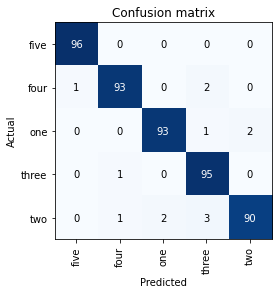

In [2]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

# 3. Summary and Conclusion
Summarize your new results and state your lab3 and lab4 results.

### Previous Labs ###
#### Lab 3 summary ####
- *Augmentations used: minimal rotation, horizontal flipping, perspective warping, brightness changes and contrast changes. Zoom not used in case clipping of fingers occurred.*
- *Training strategy: used base learning rate of `lr_steep` from the `lr_find()` function, which was approximately 0.003. For later epochs, the slice method was used to provide interpolated learning rates somewhere between `lr_steep/1000` and `lr_steep/10`.*
- Best accuracy achieved: 52%
- *Confusion Matrix: the model appears to get very confused with twos and threes. Perhaps better imagery that distinguishes these two is needed.*
- Lab 3 Conclusion: *I would not be satisfied with these results in the real world. I would probably try to get a much bigger dataset (or higher quality) and start over.*

#### Lab 4 summary ####
- *Results from production analysis: 0.605*
- *Training loss results from lab 3: 0.45*
- *Validation accuracy from lab 3: 0.48*
- *Validation accuracy appears to be higher in the production environment. This may be due to "average" photos of the fingers being used, whereas in the training data, more extreme photos were used as an attempt to better train the model (eg. close up, far away, weird orientations, etc)*
- *For a production model, this is still unsatisfactory. The model is only getting it right 2/3 of the time. In using deep learning for any type of practical model, it's hard to imagine a scenario where this would be an acceptable amount of error*
- *Future work should try with a larger and more extensive data set to see if the model learns better.*


### Results of this Lab ###
- *The final model was able to achieve 97% accuracy with the fine_tune() function using 6 epochs, and a dataset of 870 training images and 96 validation images per label*. *Contrasting this with lab 3/4, where there were 40 training and 10 validation images per label*.
- `lr_min` *was used instead of* `lr_steep` *in the* `base_lr` *parameter of the * `fine_tune()` *function, because as the graph depicts, the steepest slope was found on the very left side of the graph, which led to poor results when attempted (less than 20% accuracy).*
- *It's possible that the model could be improved even further, but 97% is a very high accuracy, and the effort it would take to improve beyond 97% is likely to yield diminishing returns. Nevertheless, different batch sizes, number of epochs, and other parameters could be explored further to potentially yield even better results.*




# 4. Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating
while working on this assignment.

*- I liked seeing how important the data is to model performance. Garbage in = garbage out.*
*- I disliked that this is the final lab. It would have been great to have a lab on some other types of DL like NLP or a suggestion based lab, but ultimately the three 'comprehensive' labs that together made something bigger was very rewarding.*
*- I had a bit of trouble solving the learning rate problem. The steep learning rate was found to be at an inconvenient part of the graph (ie. an anomaly), and so it skewed the data. It's important to look at what the data is saying and not just blindly follow programming steps.*

